## Introduction 

Overfitting is one of the most important issues in machine learning, if not the most important. 

In this post, I'll illustrate overfitting in the context of a small 2D classification problem. 

But what is going to be explained here is important, and should be kept in mind at all times when working on more complex problems. 

You will learn: 

* what is overfitting, and see it with your own eyes
* how to avoid overfitting 
* that if you use a neural network that is too complex for the amount of data you have, you'll just get crap.
* that complex models are still necessary to deal with complex problems, otherwise you get underfitting. 

First, let's setup our tools:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(0xdeadbeef)

## Building a small dataset

Let's create a sample of examples with two values x1 and x2, with two categories. 
For category 0, the underlying probability distribution is a 2D Gaussian centered on (0,0), with width = 1 along both directions. For category 1, the Gaussian is centered on (1,1). We assign label 0 to category 0, and label 1 to category 1.

In [2]:
def make_sample(nexamples, means=([0.,0.],[1.,1.]), sigma=1.):
    normal = np.random.multivariate_normal
    # squared width:
    s2 = sigma**2.
    # below, we provide the coordinates of the mean as 
    # a first argument, and then the covariance matrix
    # which describes the width of the Gaussian along the 
    # two directions. 
    # we generate nexamples examples for each category
    sgx0 = normal(means[0], [[s2, 0.], [0.,s2]], nexamples)
    sgx1 = normal(means[1], [[s2, 0.], [0.,s2]], nexamples)
    # setting the labels for each category
    sgy0 = np.zeros((nexamples,))
    sgy1 = np.ones((nexamples,))
    sgx = np.concatenate([sgx0,sgx1])
    sgy = np.concatenate([sgy0,sgy1])
    return sgx, sgy

Here, we create a very small training sample with only 30 examples per category, and a test sample with 200 examples per category. We're using such a small training sample because, as will be shown in this post, small samples are very easy to overfit. 

In [3]:
sgx, sgy = make_sample(30)
tgx, tgy = make_sample(200)

Text(0, 0.5, 'x2')

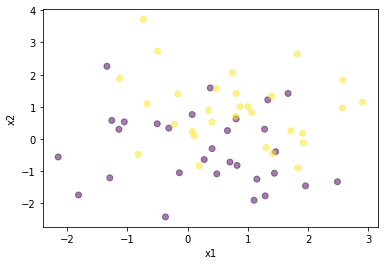

In [4]:
# note how the two categories are plotted
# together in one go by providing the 
# label array as color argument (c=sgy)
plt.scatter(sgx[:,0], sgx[:,1], alpha=0.5, c=sgy)
plt.xlabel('x1')
plt.ylabel('x2')

We see that with such a low number of examples, it is not obvious that the samples follow Gaussian probability density functions. Also, since the Gaussians are so close, it's going to be quite difficult to separate the two categories. 

## Overfitting 

Let's try anyway with a neural network from scikit-learn. Here is an explanation of the parameters I use below: 

* three hidden layers with 50 neurons each. I've chosen this fairly complex configuration on purpose to illustrate overfitting, which occurs when the model is too complex for the amount of data in the training sample. 
* ReLU activation, because ReLU makes the training easier in neural nets with hidden layers. 
* an increased maximum number of iterations, so that the network has time to converge
* a fixed random seed so that you can get the exact same results as me, every time you run the code

In [5]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=10000, random_state=1)
mlp.fit(sgx,sgy)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Now let's define a small function to plot our results. The function will plot the examples in the two categories, as well as the probability that an (x1,x2) point belongs to category 1 (black means that this probability is close to 1, and white to 0.)

In [10]:
def plot_result(sample, targets, linrange=(-5,5,101)):
    xmin, xmax, npoints = linrange
    gridx1, gridx2 = np.meshgrid(np.linspace(xmin,xmax,npoints), np.linspace(xmin,xmax,npoints))
    grid = np.c_[gridx1.flatten(), gridx2.flatten()]
    probs = mlp.predict_proba(grid)
    plt.figure(figsize=(10,10))
    plt.pcolor(gridx1, gridx2, probs[:,1].reshape(npoints,npoints), cmap='binary')
    plt.colorbar()
    plt.scatter(sample[:,0], sample[:,1], c=targets, cmap='plasma', alpha=0.5)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

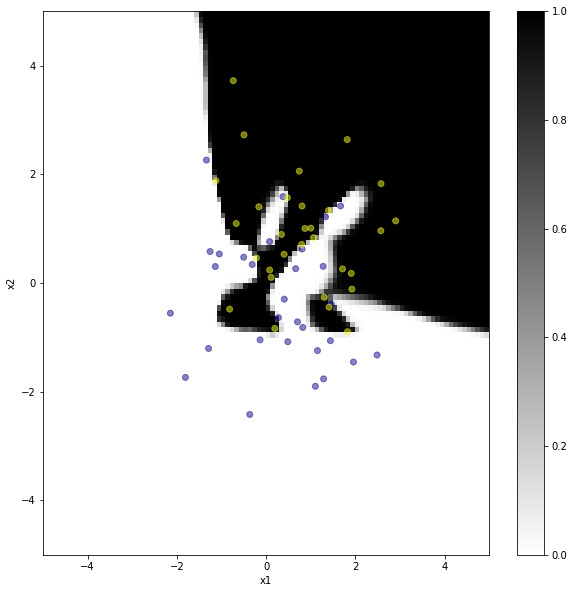

In [11]:
plot_result(sgx,sgy)

Very nice eagle, but the probability distribution is very far from being optimal. We see that at the frontier, the neural network does its best to follow the patterns of the training sample. It is able to do that because its large number of parameters make it very flexible and adaptive.  

But let's see what happens if we plot the probability distribution with the larger test sample:

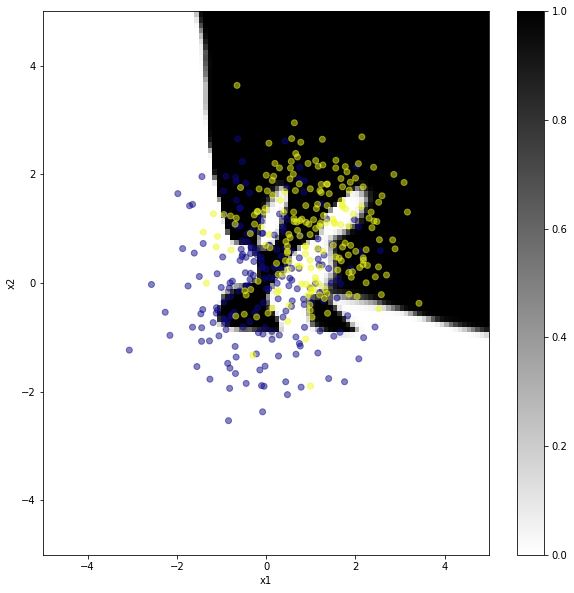

In [12]:
plot_result(tgx,tgy)

There are many examples that are classified in the wrong category. This neural network is very good with the training sample, but it has lost its generality and is thus useless in practice. 

**This is overfitting.**

## Fixing overfitting 

Now let's try again, but with a much more simple network, with a single layer with five neurons. The network is trained with the small training sample, and displayed with the larger test sample:

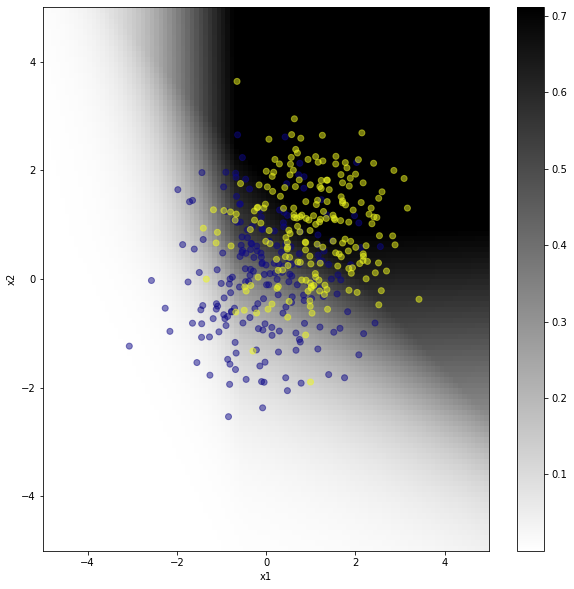

In [13]:
mlp = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=10000, random_state=1)
mlp.fit(sgx,sgy)
plot_result(tgx,tgy)

This time, overfitting is much less of an issue. The network does not have enough parameters to be able to follow the random patterns of the training sample. Therefore, it behaves quite well on the test sample. 

Let's try something else. This time, we use the complex network, but we provide much more training data: 10,000 examples per category instead of 30.  

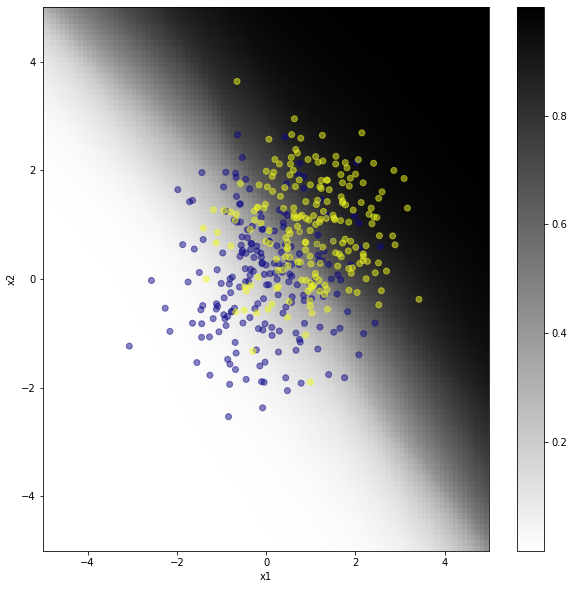

In [14]:
sgx, sgy = make_sample(10000)
mlp = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=10000, random_state=1)
mlp.fit(sgx,sgy)
plot_result(tgx, tgy)

The network took a bit longer to train but this time, there is enough training data to properly constrain the parameters of the network, and the classification performance is going to be good in general.

## So why do we need complex networks then? 

Well, to describe complex data! And for these networks to be efficient in this task, we will need a lot of training data. 

In this section, we'll build a complex dataset with a lot of data, and see how well we can classify it. 

To build the dataset, we just reuse our make_sample function several times and concatenate the resulting samples: 

In [16]:
sgxa, sgya = make_sample(1000, ([0.,0],[3.,3.]), 0.3)
sgxb, sgyb = make_sample(1000, ([1.,1],[4.,4.]), 0.3)
sgxc, sgyc = make_sample(1000, ([5.,5.],[-2.,-2.]), 0.6)
sgxd, sgyd = make_sample(1000, ([-1,3.],[3.,-1.]), 0.3)

sgx = np.concatenate([sgxa,sgxb,sgxc,sgxd])
sgy = np.concatenate([sgya,sgyb,sgyc,sgyd])

Text(0, 0.5, 'x2')

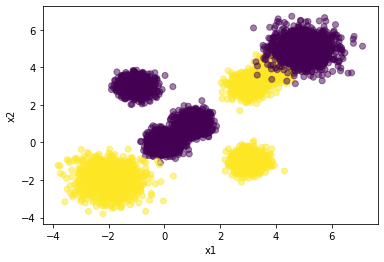

In [17]:
plt.scatter(sgx[:,0], sgx[:,1], alpha=0.5, c=sgy)
plt.xlabel('x1')
plt.ylabel('x2')

Now, let's build a small network and see if we can classify that. 

In [18]:
mlp = MLPClassifier(hidden_layer_sizes=(3,), activation='relu', max_iter=10000, random_state=1)
mlp.fit(sgx,sgy)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

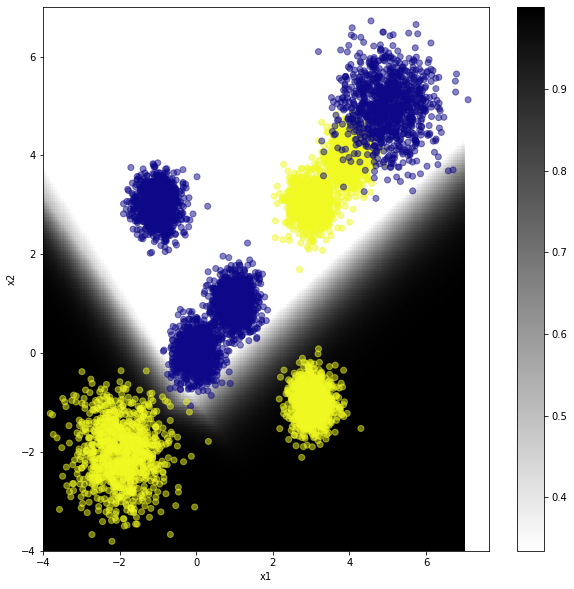

In [19]:
plot_result(sgx,sgy,linrange=(-4,7,201))

The network does not have enough parameters to fit the training data. 

**This is underfitting.**

Still, it does quite a good job with its three neurons. 

Let's increase the number of neurons on the hidden layer a bit:

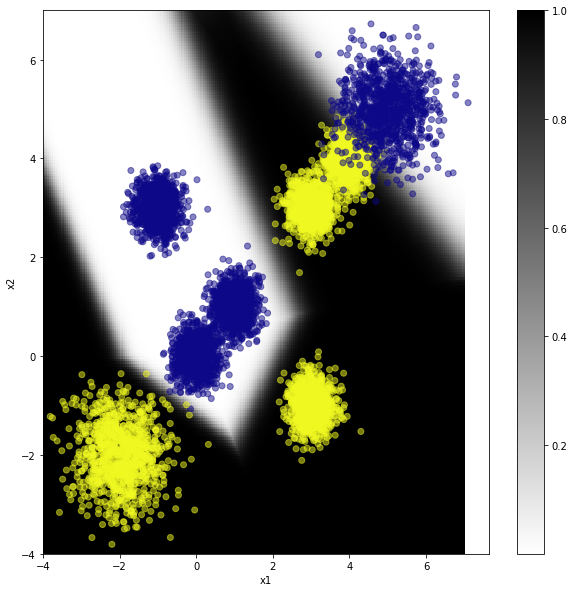

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=10000, random_state=1)
mlp.fit(sgx,sgy)
plot_result(sgx,sgy,linrange=(-4,7,201))

Wow! 5 neurons is already enough to fit the data, but we're a bit lucky. With a different topology we could have missed a patch. 

Let's increase the complexity of the model even further:

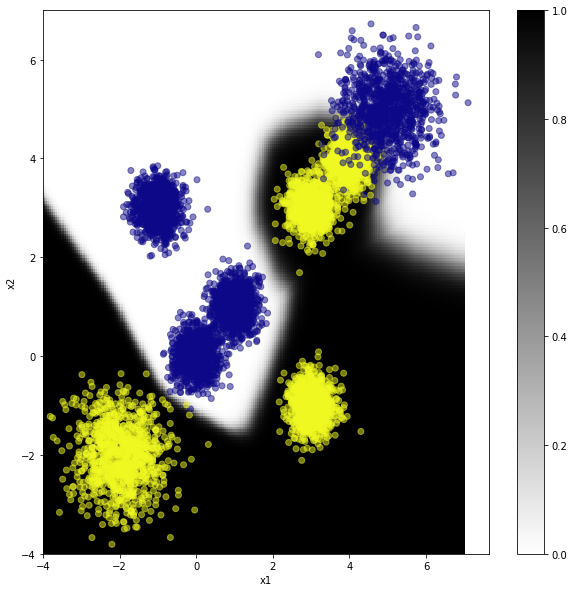

In [24]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', max_iter=10000, random_state=1)
mlp.fit(sgx,sgy)
plot_result(sgx,sgy,linrange=(-4,7,201))

Still no overfitting. The network now shows a smooth boundary, and I'm pretty sure it would be able to adapt further if needed. 

**Exercise**

* The previous network, with three hidden layers of 50 neurons each, is way too complex for this simple dataset. Go back to the previous cell, and try and simplify the network, studying different possibilities : less layers, less neurons per layer. 